In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `C:\Users\Zac\BME574`


In [2]:
Pkg.add(["Random","Colors","MAT","LinearAlgebra","MLDatasets","Convex","SCS","Distributions","Statistics","CairoMakie"])

   Resolving package versions...
  No Changes to `C:\Users\Zac\BME574\Project.toml`
  No Changes to `C:\Users\Zac\BME574\Manifest.toml`


In [3]:
using  Colors, MLDatasets, LinearAlgebra, Statistics, Convex, SCS, CairoMakie

In [4]:
dataset = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [5]:
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [6]:
dataset.targets

60000-element Vector{Int64}:
 5
 0
 4
 1
 9
 2
 1
 3
 1
 4
 3
 5
 3
 ⋮
 7
 8
 9
 2
 9
 5
 1
 8
 3
 5
 6
 8

In [7]:
dataset.features

28×28×60000 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.0    

In [8]:
Gray.(dataset.features[:,:,5]')

## BME 574 Midterm Exam (take-home)

The dataset above is the famous MNIST dataset of handwritten digits (28x28 grayscale images).
The challenge for this midterm is to find the most informative pixels for each digit from this dataset
using techniques that you have learning previously.  Here is how to start:
1. Create a set of output (label) vectors $\{y_j\}$ of length 10 that represent the labels (0-9)
here are a few examples:
$$
\begin{align}
^{"}1^{"}=\begin{bmatrix} 1\\0\\0\\ \vdots \\0 \end{bmatrix}
\end{align}
$$
$$
\begin{align}
^{"}3^{"}=\begin{bmatrix} 0\\0\\1\\ \vdots \\0 \end{bmatrix}
\end{align}
$$
$$
\begin{align}
^{"}0^{"}=\begin{bmatrix} 0\\0\\0\\ \vdots \\1 \end{bmatrix}
\end{align}
$$
2. Now let $B$ be the set of output (label) vectors

$$
\begin{align}
B = \begin{bmatrix} y_{1} & y_{2} & y_{3} & \ldots & y_{n}\end{bmatrix}
\end{align}
$$

3. Let the matrix $A$ be the corresponding reshaped (vectorized) MNIST images (one in each row)

$$
\begin{align}
A = \begin{bmatrix} x_{1} & x_{2} & x_{3} & \ldots & x_{n}\end{bmatrix}
\end{align}
$$

4. $AX = B$ maps from the image space to the label space

Your task is to use solvers for $AX=B$ that promote sparsity to rank the pixels in the MNIST dataset that are most informative for correctly labeling the digits. You will have to come up with your own heuristics or empirical rules for this. Be sure to visualize the results from X. Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible. Redo the analysis with each digit individually to ﬁnd the most important pixels for each digit. Think about the interpretation of what you are doing with this $AX = B$ problem.
Hint: for testing, it may be a good idea to start with a smaller dataset (e.g. 1000 images)

In [11]:
function lasso(A, y, λ1)
    (T, K) = (size(A, 1), size(A, 2))
    Q = A'A / T
    c = A'y / T                      #c'b = Y'X*b

    x = Variable(K)              #define variables to optimize over
    L1 = quadform(x, Q; assume_psd=true)            #b'Q*b
    L2 = dot(c, x)                 #c'b
    L3 = norm(x, 1)                #sum(|b|)

    problem = minimize(L1 - 2 * L2 + λ1 * L3)
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(x))
end

function predPix(a,x,usepixels)
    #A is list of actual pixels, x is weights, usepixels is a list of indices for which pixels to use 
    y = a[:,usepixels]*x[usepixels,:]
    ynorm = zeros(size(y))
    for ii = 1:size(y,1)
        ynorm[ii,:] = y[ii,:]./norm(y[ii,:])
    end
    pixpred = argmax(ynorm; dims=1)
    return (ynorm,prixpred)
end

function scorepix(ynorm,b)
    return sum(abs(b-ynorm);dims=2)#sum of the absolute errors of each vector seems like a good metric since everything is normalized
end

scorepix (generic function with 1 method)

In [12]:
A =  (reshape(dataset.features,(:,length(dataset.targets))))'# Each row is an image, each column a pixel (ith row, jth column -> ith img, jth pix)

60000×784 adjoint(::Matrix{Float32}) with eltype Float32:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  

In [13]:
B = zeros(Float32,10,length(dataset.targets))
for ii = 1:length(dataset.targets)
    B[dataset.targets[ii]+1,ii] = 1#offset for 0
end
B = circshift(B,(-1,0))'#move 0 to end and reshape to coorect aspect
# row # in B represent images, column # images

60000×10 adjoint(::Matrix{Float32}) with eltype Float32:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

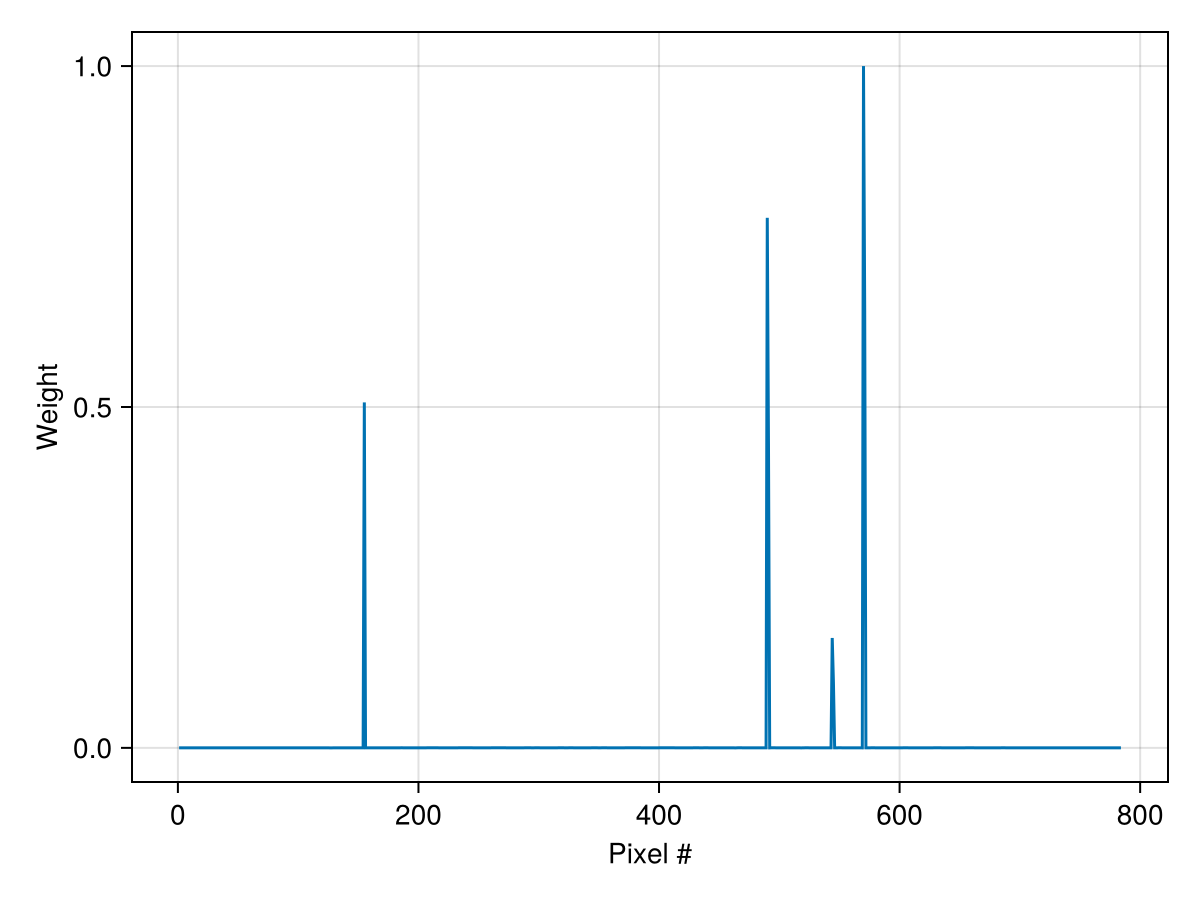

In [14]:
pixlist1 = lasso(A,B[:,2],0.1)
normPM1 = pixlist1./maximum(abs.(pixlist1))

f0 = Figure()
ax = Axis(f0[1,1],
    xlabel = "Pixel #",
    ylabel = "Weight"
)
lines!(ax,normPM1)
#hax = Axis(f0[1,2])
#hist!(hax,abs.(normPM1))
f0

In [15]:
testDigit = 1

λs = 10.0.^range(-6,6,61)

ntot = length(λs)
npixs = zeros(ntot)
pixthresh = 1E-5

testNom = zeros(10,1)
testNom[testDigit+1] = 1
testNom = circshift(testNom,(-1,0))
score = zeros(ntot)

for ii = 1:ntot
    #sparse fit 
    pixlist1 = lasso(A,B[:,testDigit],λs[ii])

    #select pixels to use
    normPM1 = pixlist1./maximum(abs.(pixlist1))
    usepix = findall(abs.(normPM1) .> pixthresh)
    npixs[ii] = length(usepix)

    # evaluate using those pixels
    y = A[:,usepix]*pixlist1[usepix,:]#this should be 0 if it's a different digit and 1 if it's the digit in question
    
    score[ii] = sum(abs.(y.-B[:,testDigit]))#only looks at prediction for digit in question. #high score is bad
    # I suppose it's possible that a different digit would be better predicted by even the same pixels   
end

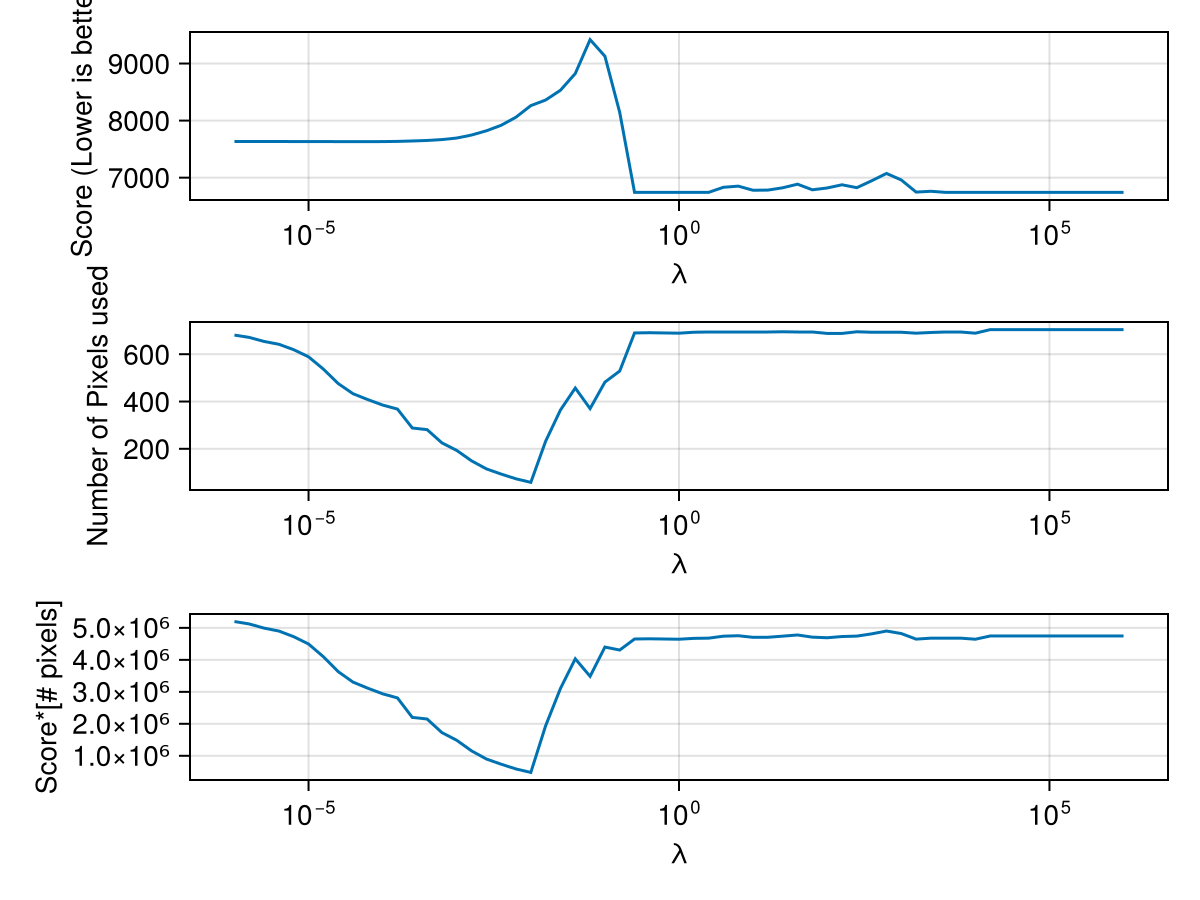

In [16]:
fig1 = Figure()
ax1 = Axis(fig1[1,1],
    xlabel = "λ",
    ylabel = "Score (Lower is better)",
    xscale = log10
)
lines!(ax1,λs,score)
ax2 = Axis(fig1[2,1],
    xlabel = "λ",
    ylabel = "Number of Pixels used",
    xscale = log10
)
lines!(ax2,λs,npixs)
ax3 = Axis(fig1[3,1],
    xlabel = "λ",
    ylabel = "Score*[# pixels]",
    xscale = log10
)
lines!(ax3,λs,npixs.*score)
fig1

In [17]:
λs = 10.0.^range(-4,3,15)#originally based on previous plots under the assumption that no digit will have too different optimal fitting parameters 
#that assumption appears to have been wrong
pixthresh = 1E-8


nλ = length(λs)
npixs = zeros(nλ,10)

scores = zeros(nλ,10)


for ii = 1:nλ
    for tD = 0:9
        if tD == 0
            testDigit = 10
        else
            testDigit = tD
        end 
        #sparse fit 
        pixlist1 = lasso(A,B[:,testDigit],λs[ii])
    
        #select pixels to use
        normPM1 = pixlist1./maximum(abs.(pixlist1))
        usepix = findall(abs.(normPM1) .> pixthresh)
        npixs[ii,tD+1] = length(usepix)
    
        # evaluate using those pixels
        y = A[:,usepix]*pixlist1[usepix,:]#this should be 0 if it's a different digit and 1 if it's the digit in question
        
        scores[ii,tD+1] = sum(abs.(y.-B[:,testDigit]))#only looks at prediction for digit in question. 
        # I suppose it's possible that a different digit would be better predicted by even the same pixels   
    end
end

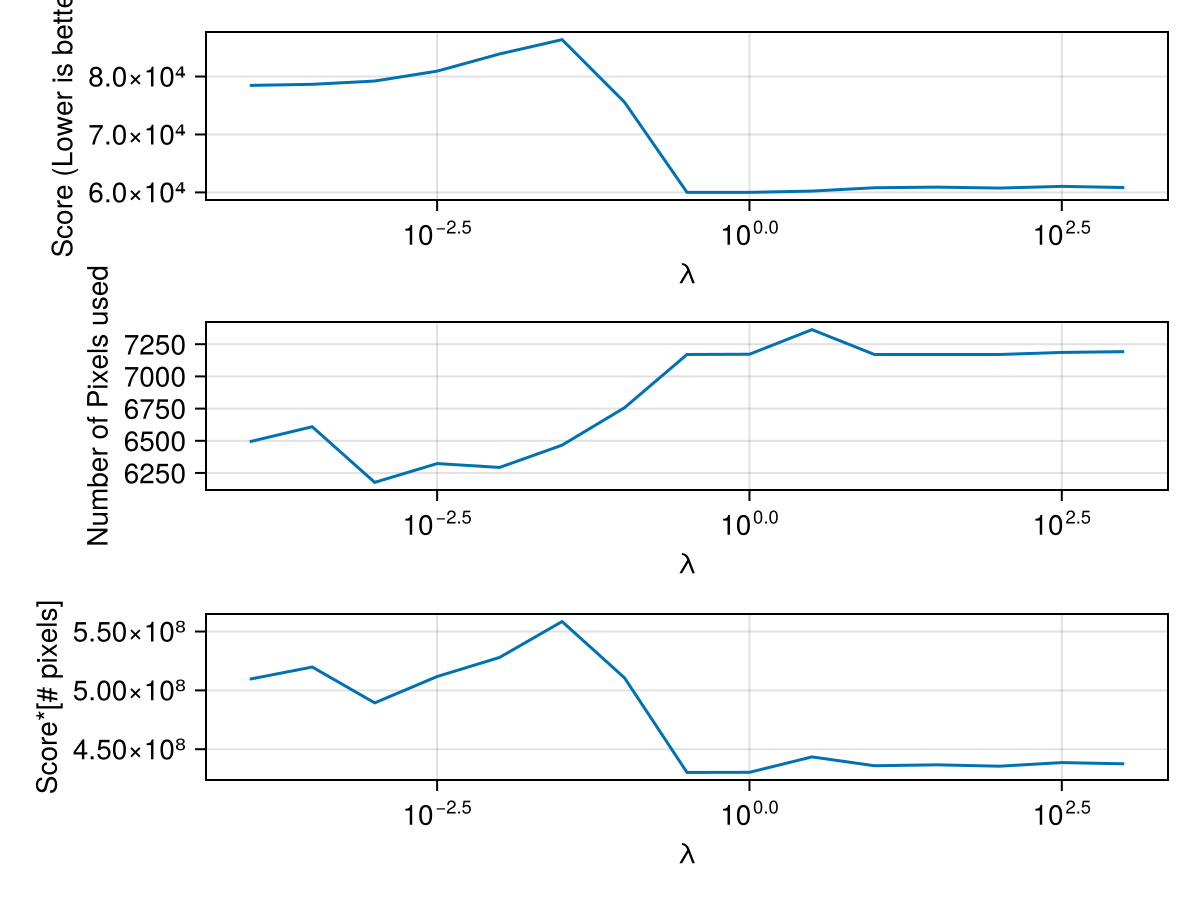

In [18]:
fig1 = Figure()
ax1 = Axis(fig1[1,1],
    xlabel = "λ",
    ylabel = "Score (Lower is better)",
    xscale = log10
)
scoresum = vec(sum(scores;dims = 2))#there is no clear indication why this needs to be converted to a vector but other things don't
pixsum = vec(sum(npixs;dims = 2))#This is an upper bound since some pixels could be used for multiple digits
lines!(ax1,λs,scoresum)
ax2 = Axis(fig1[2,1],
    xlabel = "λ",
    ylabel = "Number of Pixels used",
    xscale = log10
)
lines!(ax2,λs,pixsum)
ax3 = Axis(fig1[3,1],
    xlabel = "λ",
    ylabel = "Score*[# pixels]",
    xscale = log10
)
lines!(ax3,λs,scoresum.*pixsum)
fig1

In [ ]:
λind = argmin(scoresum.*pixsum)
pixtouse = zeros(size(A,2))
pixmat = zeros(size(A,2),10)

for tD = 0:9
    if tD == 0
        testDigit = 10
    else
        testDigit = tD
    end 
    #sparse fit 
    pixlist1 = lasso(A,B[:,testDigit],λs[λind])
    pixmat[:,tD+1] = pixlist1
    
    #select pixels to use
    normPM1 = pixlist1./maximum(abs.(pixlist1))
    usepix = findall(abs.(normPM1) .> pixthresh)
    pixtouse[usepix] .= 1 #This won't dobule count pixels
end
pixtouse = findall(pixtouse.>0)
# evaluate using those pixels
predictedDig = A[:,pixtouse]*pixmat[pixtouse,:]#this should be 0 if it's a different digit and 1 if it's the digit in question
predB = zeros(size(predictedDig,1),10)

for ii = 1:size(predictedDig,1)
    predDigVal = argmax(predictedDig[ii,:])#which is highest prediction
    predB[ii,predDigVal] = 1#offset for 0
end
predB = circshift(predB,(0,-1))#move 0 to end and reshape to coorect aspect
# row # in B represent images, column # images

nMisses = sum(sum(abs.(B-predB);dims=2).>0)
hitPerc = 100*(1 - (nMisses/size(predictedDig,1))) #10% is random choice

In [20]:
sum(predB;dims=1)

1×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  11922.0  0.0  0.0  48078.0  0.0  0.0